In [1]:
import tensorflow as tf
# our model focuses on during caption
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import IPython.display as display
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
# Download caption annotation files

annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip)
else:
    annotation_file = os.path.abspath('.') + '/annotations/captions_train2014.json'
        
# Download image files

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder
  

13510574080/13510573713 [==============================] - 326s 0us/step


In [3]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together

train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set

num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [4]:
len(train_captions), len(all_captions)

(30000, 414113)

In [5]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
temp_model = tf.keras.applications.InceptionV3(include_top = False,weights = 'imagenet')

inputs = temp_model.input
outputs = temp_model.layers[-1].output

InceptionV3 = tf.keras.Model(inputs,outputs)

87916544/87910968 [==============================] - 1s 0us/step


In [26]:
!pip install -q tqdm
from tqdm import tqdm

encode_train = sorted(set(img_name_vector))


image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = InceptionV3(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


1622it [07:41,  3.52it/s]


In [27]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [28]:
top_k = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<UN>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = calc_max_length(train_seqs)


In [29]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=1)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)

features_shape = 2048
attention_features_shape = 64

In [31]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
captions = tokenizer.sequences_to_texts(cap_train[:])

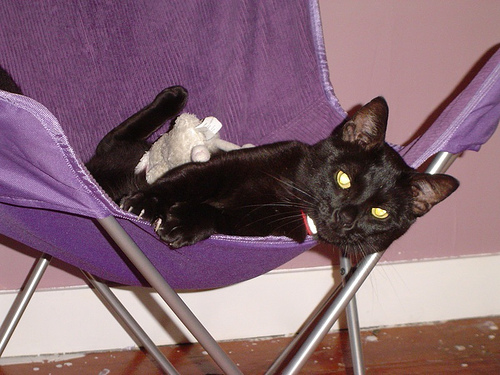

<start> a black cat with a stuffed toy in a purple <UN> chair <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


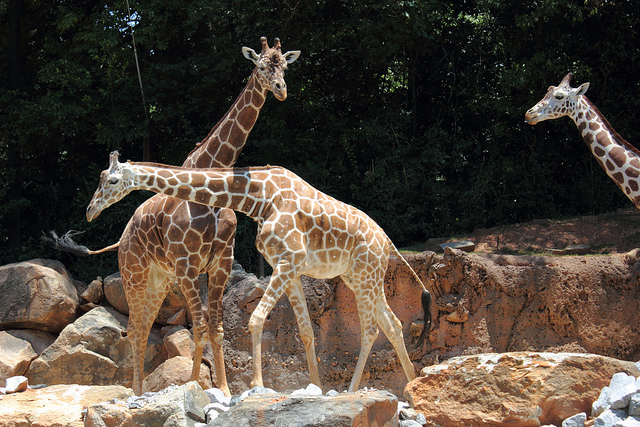

<start> a group of giraffes near each other in a rocky area <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


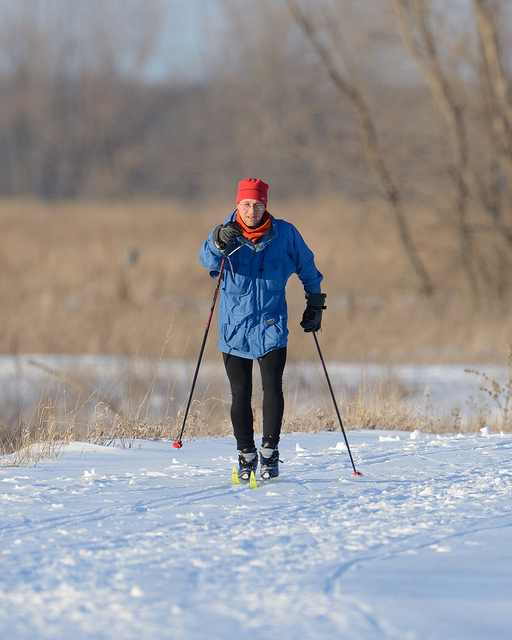

<start> the man is on the snow cross country skiing <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


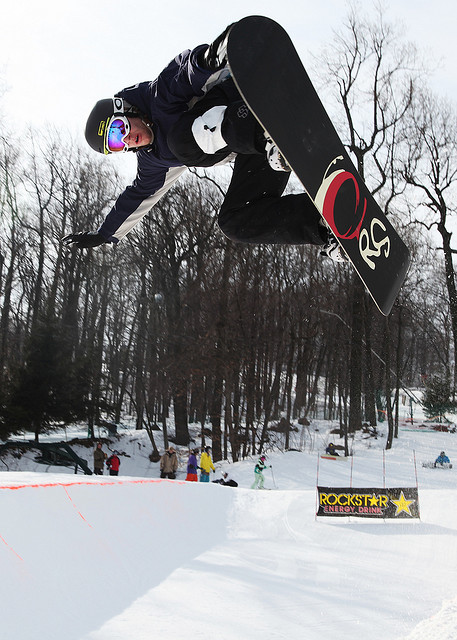

<start> a snowboarder is airborne after using a ramp <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


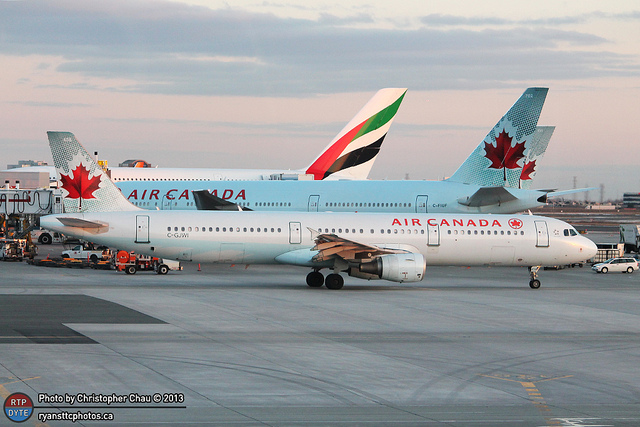

<start> there are many planes at this airport in canada <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [34]:
y = np.random.randint(64,size = 5) 
for i in y:
    display.display(Image.open(str(img_name_train[i])))
    print(captions[i])    

In [35]:
class CnnEncoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(CnnEncoder,self).__init__()
        
        self.fc = tf.keras.layers.Dense(embedding_dim)
    
    def call(self,x):
        
        x = self.fc(x)
        return tf.nn.relu(x)


In [36]:
class Attention(tf.keras.Model):
#   dims = fetaures of image from convolution
    def __init__(self,units):
        super(Attention,self).__init__()
        
        self.hiddenip = tf.keras.layers.Dense(units) 
        self.featuresip = tf.keras.layers.Dense(units)
        self.activation = tf.keras.layers.Dense(1)
    
    def call(self,hidden,features):
        
#       new_hiddenstate dims = (batch_size,1,hidden.shape[1])
        new_hiddenstate = tf.expand_dims(hidden,1)
        
#       pxlscores dims = (batch_size,64,hidden.shape[1])         
        pxlscores = tf.nn.tanh(self.hiddenip(new_hiddenstate) + self.featuresip(features))
        
        
#       self.activation(pxlscores) dims = (batch_size,64,1)
#       attention_wgts dims = (batch_size,64,1)         
        attention_wgts = tf.nn.softmax(self.activation(pxlscores), axis = 1)
        
#       scores dims = (batch_size,hidden.shape[1]) 
        context_vector = tf.reduce_sum(attention_wgts*features, axis = 1)
        
        return context_vector,attention_wgts
        

In [37]:
class RnnDecoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, units):
        super(RnnDecoder,self).__init__()

        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        
        self.attention = Attention(units)
        
        self.lstm = tf.keras.layers.LSTM(units, 
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)
        
    def call(self,word,features,hidden):
        
#       context_vector dim = (batch_size,hidden.shape[1])
#       attention_wgts dim = (batch_size,64,1)
        context_vector,attention_wgts = self.attention(hidden,features)
        
#       wordcode dim = (batch_size,1,embedding_dim)
        wordcode = self.embedding(word)
    
#       lstm_input dim = (batch_size,1,embedding_dim+hidden.shape[1])
        lstm_input = tf.concat([wordcode,tf.expand_dims(context_vector,1)],axis = -1)           
    
#       output dim, hidden dim = (batch_size,1,units), (batch_size,units)  
        output, hidden,_ = self.lstm(lstm_input)

#       output dim = (batch_size*1, units)
        output = tf.reshape(output,(-1,output.shape[2]))

#       output dim = (batch_size*1, vocab_size)
        output = self.fc(output)
        
        return  output,hidden,attention_wgts
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size,self.units))
        

In [38]:
encoder = CnnEncoder(embedding_dim)
decoder = RnnDecoder(vocab_size, embedding_dim, units)

In [39]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, 
                                                            reduction= 'none')

def loss_funct(real,pred):
    
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss = loss_object(real,pred)
#   mask is a bool type as is used for the '<pad>' token to not consider it during determination of loss
    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)
    

In [40]:
ckpt_path = './checkpoint/trains'
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,ckpt_path,max_to_keep = 5)

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [42]:
@tf.function
def train_step(image_features,num_cap):
    loss = 0
    
    ht = decoder.reset_state(num_cap.shape[0])
    
    word_embed_vector = tf.expand_dims([tokenizer.word_index['<start>']]*num_cap.shape[0],axis = 1)
    
    with tf.GradientTape() as tape:
        features = encoder(image_features)
        
        for i in range(1,num_cap.shape[1]):
            
            wordscore,ht,_ = decoder(word_embed_vector,features,ht)
            loss += loss_funct(num_cap[:,i],wordscore)
            word_embed_vector = tf.expand_dims(num_cap[:,i],axis = 1)
    
#   loss over length of caption(Average)  
    total_loss = loss/(num_cap.shape[1])
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss,trainable_variables)
    
    optimizer.apply_gradients(zip(gradients,trainable_variables))

    return loss,total_loss

In [43]:
lossplot = []

In [44]:
epoch_limit = 20


for epoch in range(start_epoch,epoch_limit):
    toc = time.time()
    total_loss = 0
    
    for (batch,(image_feature,num_cap)) in enumerate(dataset):
        loss, b_total_loss =  train_step(image_feature,num_cap)
        total_loss += b_total_loss
        
        
        if batch%100 == 0:
            print("epoch :{} Batch_no :{} batch_loss :{}".format(epoch,batch,loss))

            
    lossplot.append(total_loss)
    
    
    if epoch%5 == 0:
        ckpt_manager.save()
    
    tik = time.time()        
    print("Time :{}".format(tik-toc))


epoch :0 Batch_no :0 batch_loss :96.59615325927734
epoch :0 Batch_no :100 batch_loss :62.590858459472656
epoch :0 Batch_no :200 batch_loss :62.06764221191406
epoch :0 Batch_no :300 batch_loss :59.62860107421875
Time :419.01920890808105
epoch :1 Batch_no :0 batch_loss :61.887413024902344
epoch :1 Batch_no :100 batch_loss :54.134544372558594
epoch :1 Batch_no :200 batch_loss :53.1461296081543
epoch :1 Batch_no :300 batch_loss :45.700538635253906
Time :351.7978005409241
epoch :2 Batch_no :0 batch_loss :44.574195861816406
epoch :2 Batch_no :100 batch_loss :40.40455627441406
epoch :2 Batch_no :200 batch_loss :39.80995559692383
epoch :2 Batch_no :300 batch_loss :39.65869903564453
Time :350.713898897171
epoch :3 Batch_no :0 batch_loss :38.5203857421875
epoch :3 Batch_no :100 batch_loss :36.74922180175781
epoch :3 Batch_no :200 batch_loss :36.4295654296875
epoch :3 Batch_no :300 batch_loss :33.9803352355957
Time :349.1728165149689
epoch :4 Batch_no :0 batch_loss :35.79679489135742
epoch :4 Bat

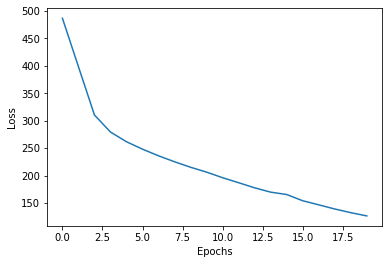

In [45]:
plt.plot(lossplot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [46]:
def caption(image_path):
    
    attention_plot = np.zeros((max_length,attention_features_shape))
    
    ht = decoder.reset_state(1)
    image_val = tf.expand_dims(load_image(image_path)[0], 0)
    image_val = InceptionV3(image_val)
    cnninput = tf.reshape(image_val, (image_val.shape[0],-1,image_val.shape[3]))
    
    features = encoder(cnninput)
    
    word_embed_vector = tf.expand_dims([tokenizer.word_index['<start>']],axis = -1)
    caption = []
    
    for i in range(max_length):
        
        wordscore, ht, attention_wgts = decoder(word_embed_vector,features,ht)
        attention_plot[i] = tf.reshape(attention_wgts, (-1,)).numpy()
        prediction = tf.random.categorical(wordscore,1)[0][0].numpy()
        caption.append(tokenizer.index_word[prediction])
        word_embed_vector = tf.expand_dims([prediction], -1)
        
        if tokenizer.index_word[prediction] == '<end>':
            return caption, attention_plot[:i+1, :]
        
    return caption, attention_plot   
           

In [47]:
def attentionplot(image_path,caption, attention_plot):
    
    temp_image = np.array(Image.open(image_path))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a cat that is laying on the floor near books <end>
Prediction Caption: a cat curled up under a book <end>


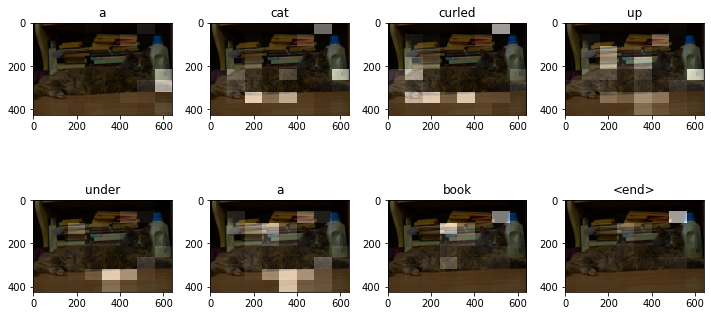

In [53]:
rid = np.random.randint(0, len(img_name_val))
image_path = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = caption(image_path)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
attentionplot(image_path, result, attention_plot)

                       

65536/64400 [==============================] - 0s 0us/step
Prediction Caption: a man riding the white surfboard <end>


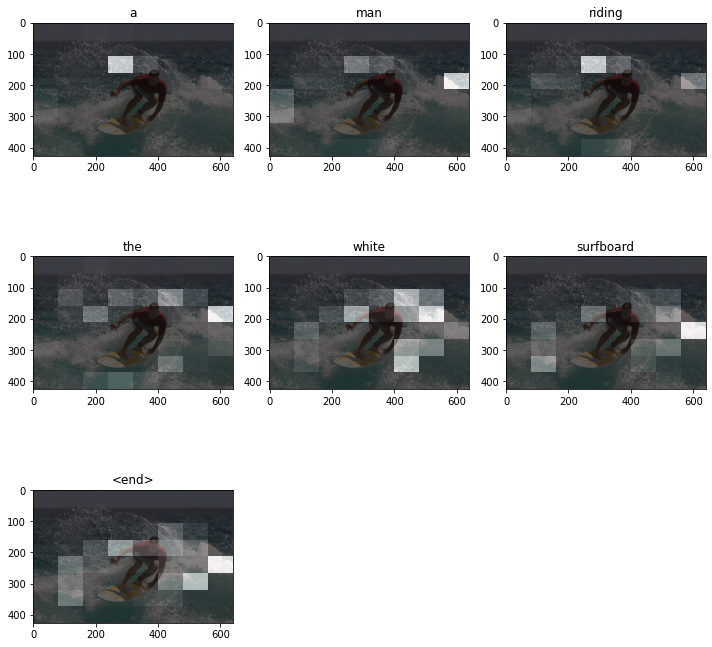

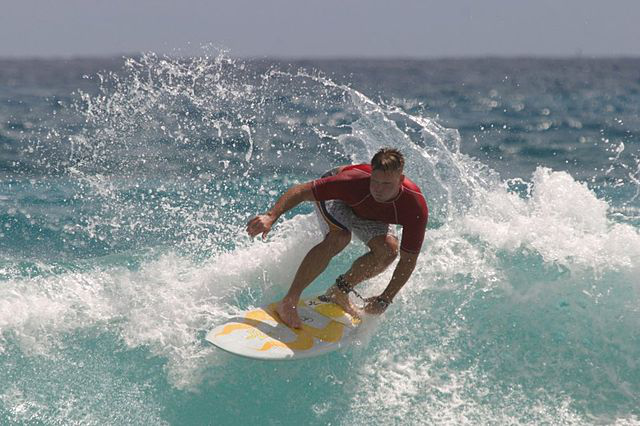

In [54]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = caption(image_path)
print ('Prediction Caption:', ' '.join(result))
attentionplot(image_path, result, attention_plot)
# opening the image
Image.open(image_path)
